<a href="https://colab.research.google.com/github/xinconggg/Machine-Learning/blob/main/Dimensionality%20Reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Curse of Dimensionality
Thousands or even millions of features are used for each training instance for many machine learning problems. These features makes the training extremly slow and makes it more challenging to find a good solution.    <br><br>

## Dimensionality Reduction
It is often possible to reduce the number of features considerably. For example, consider MNIST images, the pixels on the image borders are always white, hence these pixels can be dropped from the training set without losing much information.
<br><br>
Other than speeding up training, dimensionality reduction is also useful for data visualization. A condensed view of a high-dimensional training set can be plotted by reducing the number of dimensions down to 2 or 3.

## Main Approaches for Dimensioanlity Reduction

### 1) Projection
In most real-world problems, most training instances are not spread out uniformly across all dimensions. Many features are almost constant, while others are highly correlated. As a result, all training instances lie within or close to a much lower-dimensional subspace of high-dimensional space. Below is an image showing a 3D dataset lying close to a 2D subspace:
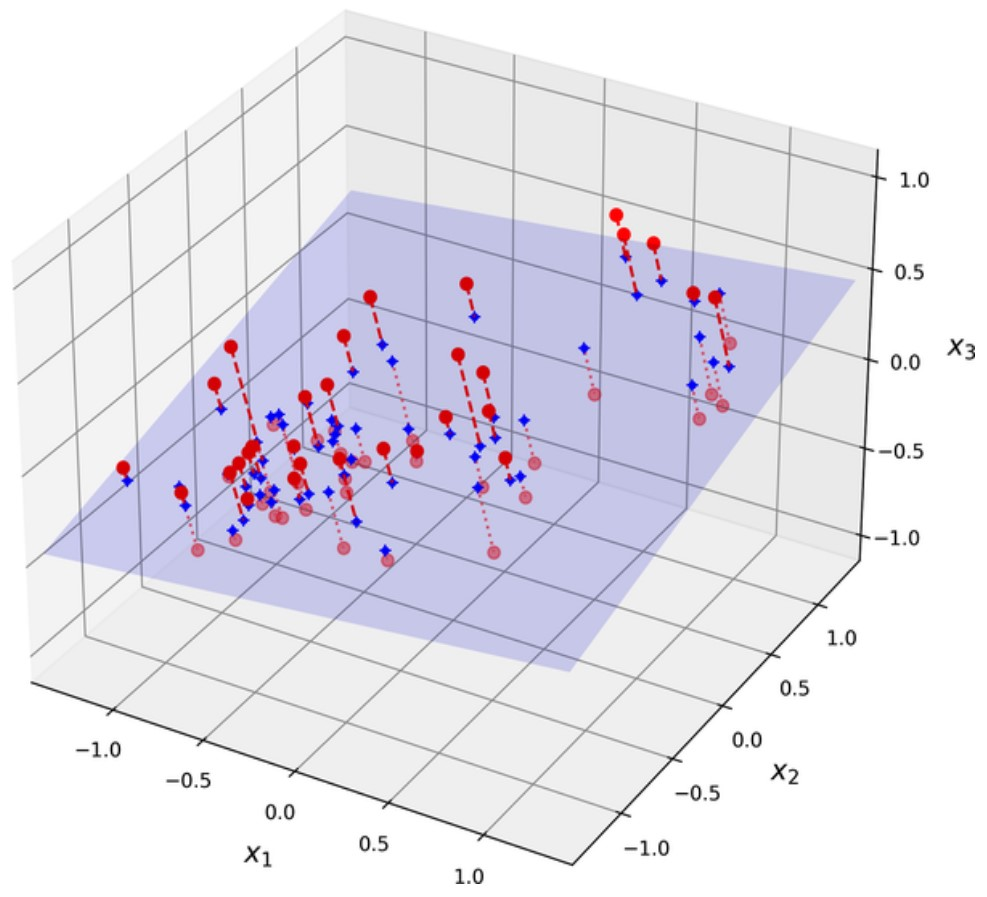
### 2) Manifold Learning
Projection is not always the best approach to dimensionality reduction. In some cases, the subspace may twist and turn. The goal of Manifold Learning is to uncover the underlying structure of the data by mapping it to a lower-dimensional space while preserving its essential geometric and topological properties.



## Principal Component Analysis (PCA)
The most popular dimensionality reduction algorithm. First it identifies the hyperplane that lies closest to the data, then it projects the data onto it.
<br><br>
Princpal components of a training set can be found using a standard matrix factorization technique called ```Singular Value Decomposition (SVD)``` that can decompose the trianing set matrix **X** into the matrix multiplcation of 3 matrices: $𝕌$, $𝚺$, $𝕍^t$, where $𝕍$ contains the unit vectors that define all the wanted principal components.

In [1]:
# Generate a small 3D dataset, X, that is oval in shape, rotated in 3D space, with points distributed unevenly and with a lot of noise
import numpy as np
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))  # initialize 3D dataset
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 * np.random.randn(m, 3)  # add more noise
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X += [0.2, 0, 0.2]  # shift a bit

### Using NumPy to implement PCA

NumPy's ```svd``` function can be used to obtail all the principal components (PC) of the 3D training set, it then extracts the 2 unit vectors that define the first two PCs.

In [2]:
import numpy as np

X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt[0]
c2 = Vt[1]

## Projecting down to d Dimensions
Once all PCs have been identified, the dimensionality of the dataset can be reduced down to d dimensions by projecting it onto the hyperplane defined by the first d principal components.

<br>
To project the training set onto the hyperplane and obtain a reduced dataset $X_{d-proj}$ with d dimensions, compute the matrix multiplcation of the training set matrix $X$ by the matrix $W_d$, defined as the matrix containing the first d columns of $𝕍$.

<br>
$X_{d-proj}$ = $XW_d$
<br><br>

The following code projects the training set onto the plane defined by the first 2 PCs:

In [3]:
W2 = Vt[:2].T
X2D = X_centered @ W2

### Using Scikit-Learn to implement PCA
Scikit-Learn's PCA class uses SVD to implement PCA. The following code reduces the dimensionality of the dataset down to 2D (note that the centering of data is automatically taken care of).

In [4]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [5]:
pca.components_

array([[ 0.67857588,  0.70073508,  0.22023881],
       [ 0.72817329, -0.6811147 , -0.07646185]])

## Explained Variance Ratio
This ratio indicates the proportion of the dataset's variance that lies along each principal component.

In [6]:
pca.explained_variance_ratio_

array([0.7578477 , 0.15186921])

This output tells us that about 76% of the dataset's variance lies along the first PC and about 15% lies along the second PC. Meaning that about 9% of the dataset's variance lies along the third PC.

## Choosing the Right Number of Dimensionality
Instead of randomly choosing the number of dimensions, it is better to choose the number of dimensions that add up to a sufficiently large portion of the variance--say 95%.
<br><br>
The following code loads and splits the MNIST dataset and performs PCA without reducing dimensionality, then computes the minimum number of dimensions required to preserve 95% of the training set's variance:

In [7]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False, parser="auto")
X_train, y_train = mnist.data[:60_000], mnist.target[:60_000]
X_test, y_test = mnist.data[60_000:], mnist.target[60_000:]

pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1  # d equals 154

Instead of specifying the number of prinpical components that you want to preserve, set ```n_components``` to be a float, indicating the ratio of variance that is wished to be preserved:

In [8]:
pca = PCA(n_components=0.95) # want to preserve 95% of training set's variance
X_reduced = pca.fit_transform(X_train)

If dimensionality reduction is used as a preprocessing step for a supervised learning task (e.g. Classification), the number of dimensions can be tuned.
<br> <br>
For example, the following code creates a 2-step pipeline, first reducing dimensionality using PCA, then classifying using a random forest. Next, it uses ```RandomizedSearchCV``` to find a good combination of hyperparameters for both PCA and the random forest classifier.

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline

clf = make_pipeline(PCA(random_state=42),
                    RandomForestClassifier(random_state=42))
param_distrib = {
    "pca__n_components": np.arange(10, 80),
    "randomforestclassifier__n_estimators": np.arange(50, 500)
}
rnd_search = RandomizedSearchCV(clf, param_distrib, n_iter=10, cv=3,
                                random_state=42)
rnd_search.fit(X_train[:1000], y_train[:1000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=42))]),
                   param_distributions={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       6...
       414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426,
       427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439,
       440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452,
       453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465,
       466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478,
       479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491,
       492, 493, 494, 495, 496, 497, 498, 499])},
                   random_state=42)

In [10]:
print(rnd_search.best_params_)

{'randomforestclassifier__n_estimators': 475, 'pca__n_components': 57}


475 tree were used in the random forest and 57 principal components were retained. The 784-dimensional dataset has been reduced to just 57 dimensions.

## Random Projection
The random projection algorithm projects the data to a lower-dimensional space using a random linear projection. Even though the process is random, such projection is actually very likely to preserve distances fairly well. Hence, 2 similar instances will remain similar after the projection and conversely, 2 different instances will remain different after the projection. <br><br>
The more dimension dropped equals to more information lost. Therefore, to choose the optimal number of dimensions, the equation implemented by ```johnson_lindenstrauss_min_dim``` function is used:

In [11]:
from sklearn.random_projection import johnson_lindenstrauss_min_dim

m, ε = 5_000, 0.1
d = johnson_lindenstrauss_min_dim(m, eps=ε)
d

7300

Now, a random matrix **P**, of size (*d* x *n*), can be generated, where each item is sampled randomly from a Gaussian distribution with mean 0 and variance 1/*d*. It is then used to project a dataset from *n* dimensions down to *d*:

In [12]:
n = 20000
np.random.seed(42)
P = np.random.rand(d, n) / np.sqrt(d) # Standard Deviation = sqrt(Variance)
X = np.random.randn(m, n) # generate a fake dataset
X_reduced = X @ P.T

### Using Skikit-Learn for Random Projection


In [13]:
from sklearn.random_projection import GaussianRandomProjection

gaussian_rnd_proj = GaussianRandomProjection(eps=ε, random_state=42)
X_reduced = gaussian_rnd_proj.fit_transform(X) # same result as above

## Locally Linear Embedding (LLE)

LLE is a *Non-Linear Dimensionality Reduction* (NLDR) technique. Unlike PCA and random projection, it is a manifold learning technique that does not rely on projections.
<br>
LLE works by first measuring how each training instance linearly relates to its nearest neighbors, and then looks for a low-dimensional representation of the trianing set where these local relationships are best preserved.
<br><br>
The following code makes a "Swiss Roll" then uses Scikit-Learn's ```LocallyLinearEmbedding``` class to unroll it:

In [14]:
from sklearn.datasets import make_swiss_roll
from sklearn.manifold import LocallyLinearEmbedding

X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_unrolled = lle.fit_transform(X_swiss)

The following output shows the unrolled Swiss roll, with the distances between instanaces being well preserved.
<br>
However, on a larger scale, the unrolled Swiss roll would be a rectangle.

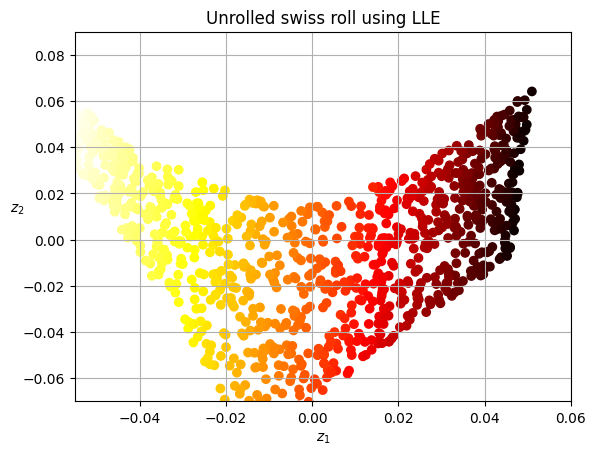

In [15]:
import matplotlib.pyplot as plt

plt.scatter(X_unrolled[:, 0], X_unrolled[:, 1],
            c=t, cmap="hot")
plt.xlabel("$z_1$")
plt.ylabel("$z_2$", rotation=0)
plt.axis([-0.055, 0.060, -0.070, 0.090])
plt.grid(True)

plt.title("Unrolled swiss roll using LLE")
plt.show()